# Walk forward analysis - Part 2 - Predicting the args for OOS periods

* In the [previous notebook](https://github.com/kevinhhl/Pinescript-Projects/blob/5ca8a0b4ef847159ae93bfedb3cf8c7a67b3d3a1/Backtesting%20frameworks/Walk%20Forward%20Analysis%20V1.ipynb), we built a script combining OOS periods to perform WFA using data exported from TradingView.

* One of the parameters in my NQ strategy - called "Brick" - acts as a filter to prevent trades from taking place if ATR is below the inputted threshold. Logically, the optimal value should correlate with expected market volatility. Although we don't have a crystal ball to quantify realized volatility, it still makes sense to use VIX as a predictor.

To train the model, we feed weekly VIX and performance benchmarks (refer to previous script) and apply a linear regression model to fit the training data set. One question we need to address is the appropriate window size for training.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import yfinance as yf
import matplotlib.pyplot as plt  

## Loading the data

From [previous notebook](https://github.com/kevinhhl/Pinescript-Projects/blob/5ca8a0b4ef847159ae93bfedb3cf8c7a67b3d3a1/Backtesting%20frameworks/Walk%20Forward%20Analysis%20V1.ipynb):

In [2]:
df_wfa_template = pd.read_pickle('df_wfa_template.pickle')
df_wfa_template.tail()

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,benchmark,OOS Date1,OOS Date2,OOS ATR,OOS Brick
465,2023_Week #26,2023-06-26,2023-07-02,28,2,-8.75,2023-07-03,2023-07-09,2.0,26.0
466,2023_Week #27,2023-07-03,2023-07-09,22,2,-0.50,2023-07-10,2023-07-16,2.0,28.0
467,2023_Week #28,2023-07-10,2023-07-16,26,2,-10.60,2023-07-17,2023-07-23,2.0,28.0
468,2023_Week #29,2023-07-17,2023-07-23,18,2,18.30,2023-07-24,2023-07-30,2.0,24.0
469,2023_Week #30,2023-07-24,2023-07-30,18,2,14.40,2023-07-31,2023-08-06,2.0,21.0


In [3]:
def _categorize_in_sample(date):
    ''' Helper function to categorize in-sample group based on given date. '''
    year, week_num, day_of_week = date.isocalendar()
    return str(year) + "_Week #{:02d}".format(week_num)

df_vix = yf.download("^VIX", start="2014-01-01", end="2030-12-31")
df_vix.reset_index(inplace=True)
df_vix["Date"] = df_vix["Date"].apply(_categorize_in_sample)
df_vix = df_vix.groupby("Date").mean()
df_vix.reset_index(inplace=True)
df_vix = df_vix[['Date', 'Close']]
df_vix.rename(columns={"Close": "Avg. VIX", "Date":"In-sample Period"}, inplace=True)
df_vix["Avg. VIX"] = df_vix["Avg. VIX"].shift(-1) # Shift Avg. VIX by 1 week to account for 1 week lag in data

df_vix.tail()

[*********************100%***********************]  1 of 1 completed


,In-sample Period,Avg. VIX
496,2023_Week #27,14.080
497,2023_Week #28,13.626
498,2023_Week #29,13.740
499,2023_Week #30,15.334
500,2023_Week #31,NaN


## Training our model

* Set up the window for testing, ie LOOKBACK 
* Do some data exploration

In [4]:
LOOKBACK = 200 # No. of weeks to look back for training

In [5]:
df = df_wfa_template.copy()[LOOKBACK:]
df["Avg. VIX"] = df["In-sample Period"].map(df_vix.set_index("In-sample Period")["Avg. VIX"]) 
df = df[['In-sample Period', 'IS: Date1', 'IS: Date2', 'IS: Brick', 'IS: ATR', 'Avg. VIX']] #, 'OOS Date1', 'OOS Date2', 'OOS ATR', 'OOS Brick' ]]
df

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,Avg. VIX
200,2018_Week #22,2018-05-28,2018-06-03,15,2,12.218
201,2018_Week #23,2018-06-04,2018-06-10,42,2,12.346
202,2018_Week #24,2018-06-11,2018-06-17,8,2,13.372
203,2018_Week #25,2018-06-18,2018-06-24,6,2,16.820
204,2018_Week #26,2018-06-25,2018-07-01,12,2,15.020
...,...,...,...,...,...,...
465,2023_Week #26,2023-06-26,2023-07-02,28,2,14.505
466,2023_Week #27,2023-07-03,2023-07-09,22,2,14.080
467,2023_Week #28,2023-07-10,2023-07-16,26,2,13.626
468,2023_Week #29,2023-07-17,2023-07-23,18,2,13.740


In [6]:
# print("Correlation between Avg. VIX (Weekly) and the IS: Brick: \n = {}".format(df[['IS: Brick', 'Avg. VIX']].corr().iloc[0, 1]))
df[['IS: Brick', 'Avg. VIX']].corr()

,IS: Brick,Avg. VIX
IS: Brick,1.00000,0.44339
Avg. VIX,0.44339,1.00000


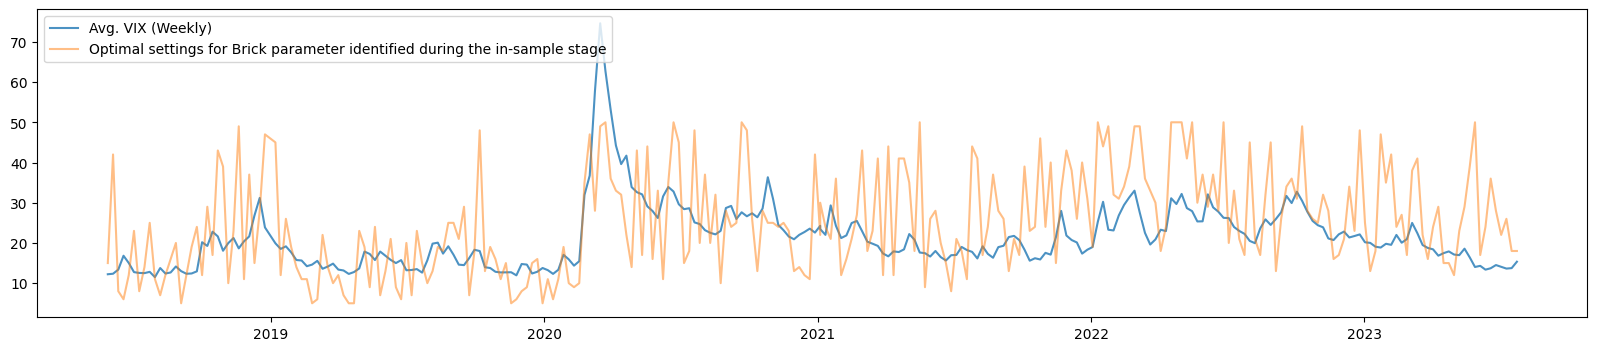

In [7]:
_df = df.copy()
_df.set_index('IS: Date1', inplace=True)
fig = plt.figure(figsize=(20, 4))
plt.plot(_df['Avg. VIX'], label='Avg. VIX (Weekly)', alpha=0.8)
plt.plot(_df['IS: Brick'], label='Optimal settings for Brick parameter identified during the in-sample stage', alpha=0.5)
plt.legend(loc='upper left')
plt.rcParams['legend.fontsize'] = 12
plt.show()

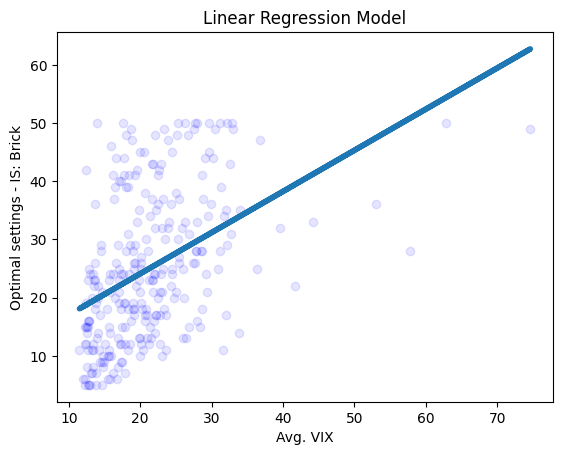

In [8]:
# Create a linear regression model
model = LinearRegression()
_df = df.dropna()

# Define the features and the target
X_train = _df['Avg. VIX'].values.reshape(-1, 1)
y_train = _df['IS: Brick'].values.reshape(-1, 1) 

# Fit the model to the training data
model.fit(X_train, y_train)

# Plot features in a scatter plot, and predictions in a line plot
plt.scatter(X_train, y_train, color='blue', alpha=0.1)
plt.plot(X_train, model.predict(X_train), linewidth=4)
plt.xlabel('Avg. VIX')
plt.ylabel('Optimal settings - IS: Brick')
plt.title('Linear Regression Model')
plt.show()

In [9]:
df.tail(10)

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,Avg. VIX
460,2023_Week #21,2023-05-22,2023-05-28,39,2,16.4125
461,2023_Week #22,2023-05-29,2023-06-04,50,2,14.0220
462,2023_Week #23,2023-06-05,2023-06-11,17,2,14.3080
463,2023_Week #24,2023-06-12,2023-06-18,24,2,13.3575
464,2023_Week #25,2023-06-19,2023-06-25,36,2,13.7100
465,2023_Week #26,2023-06-26,2023-07-02,28,2,14.5050
466,2023_Week #27,2023-07-03,2023-07-09,22,2,14.0800
467,2023_Week #28,2023-07-10,2023-07-16,26,2,13.6260
468,2023_Week #29,2023-07-17,2023-07-23,18,2,13.7400
469,2023_Week #30,2023-07-24,2023-07-30,18,2,15.3340


#### Prediction:

In [10]:
X_test = [[df.tail(1)['Avg. VIX'].iloc[0]]]
model.predict(X_test).item()

20.80917939375845

# Observations:
The in-sample settings (assumed ideal) correlates with VIX (based on previous week's average). This varies depending on the size of the window for training.

### Next step(s): 
We can build a v2 of the WFA framework (as seen in the previous notebook - v1) to see how OOS performance differs. 